# Part 03: Review Classification (Machine Learning)


In this notebook we will continue with the data we prepared in the last lecture.  Our goals will be to separate the data into high and low Ratings, compare and analyze them to notice any differences, and then to create a model to classify future Ratings as having a high or low sentiment.

In [1]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    info = f.read()

display(Markdown(info))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

# Loading Imports

In [2]:
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import os, json, joblib
from pprint import pprint
pd.set_option("display.max_columns",50)
from nltk.probability import FreqDist
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', 200)

In [3]:
!pip install -U dojo_ds -q
import dojo_ds as ds
# ds.__version__

# Import Processed Data

We created several versions of our text in the previous lecture.  We will load those again to use for analysis and classification

In [4]:
FPATHS_FILE = "config/filepaths.json"
import json
with open(FPATHS_FILE) as f:
    FPATHS = json.load(f)
FPATHS.keys()

dict_keys(['data', 'images', 'metadata', 'eda', 'models'])

In [5]:
fpath_json = FPATHS['data']['processed-nlp']['processed-reviews-with-target_json']
fpath_json

'data/processed/processed-reviews-witht-target.json'

In [6]:

df = pd.read_json(fpath_json)#joblib.load('data/processed/processed-reviews.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4363 entries, 0 to 4362
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   asin                  4363 non-null   object
 1   reviewerID            4363 non-null   object
 2   reviewText            4363 non-null   object
 3   summary               4363 non-null   object
 4   overall               4363 non-null   int64 
 5   year                  4363 non-null   int64 
 6   title                 4363 non-null   object
 7   brand                 4363 non-null   object
 8   category              4363 non-null   object
 9   review-text-full      4363 non-null   object
 10  review-text-full_raw  4363 non-null   object
 11  tokens-dirty          4363 non-null   object
 12  tokens                4363 non-null   object
 13  lemmas                4363 non-null   object
 14  tokens-dirty-joined   4363 non-null   object
 15  tokens-joined         4363 non-null   

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, skrong]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice,None
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,"[go, for, the, green, noodles, the, herb, flavor, makes, the, odd, texture, of, shirataki, much, more, palatable]","[green, noodles, herb, flavor, makes, odd, texture, shirataki, palatable]","[green, noodle, herb, flavor, make, odd, texture, shirataki, palatable]",go for the green noodles the herb flavor makes the odd texture of shirataki much more palatable,green noodles herb flavor makes odd texture shirataki palatable,green noodle herb flavor make odd texture shirataki palatable,High
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI find the best way to get rid of...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Its an awesome substitute.: I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI fin...,Its an awesome substitute.: I didn't have a problem at all with a half filled ba

## Classification Target

In [7]:
# sns.histplot

In [8]:
# Checking what values are in the overall ratings
df['target-rating'].value_counts(1)

High    0.565204
Low     0.434796
Name: target-rating, dtype: float64

In [9]:
# # Should return nothing
# create_groups(4.9)

In [10]:
# ## Use the function to create a new "rating" column with groups
# df['rating'] = df['overall'].map(create_groups)
# df['rating'].value_counts(dropna=False)

In [11]:
# # target_map = {1.0:'low',
# #              2.0:'low',
# #               # 3.0:'mid',
# #               # 4.0:'high',
# #              5.0:'high'}
# df['rating'] = df['overall'].map(create_target)
# df['rating'].value_counts(dropna=False)

### Class Balance

It's always a good idea to check the class balance when creating a classification model.  This can affect modeling bias and interpretation of metrics.

In [12]:
## Check class balance of 'rating'
df['target-rating'].value_counts(normalize=True)

High    0.565204
Low     0.434796
Name: target-rating, dtype: float64

There are more neutral Ratings any any other class, but high and low Ratings are pretty balanced.

### Length

One easy way to compare text is to compare the length of each text.  We could compare the number of character or tokens.  In this case we will compare the number of characters in each Rating for each sentiment.

In [13]:
df['length'] = df['review-text-full'].map(lambda x: len(x.split(" ")))

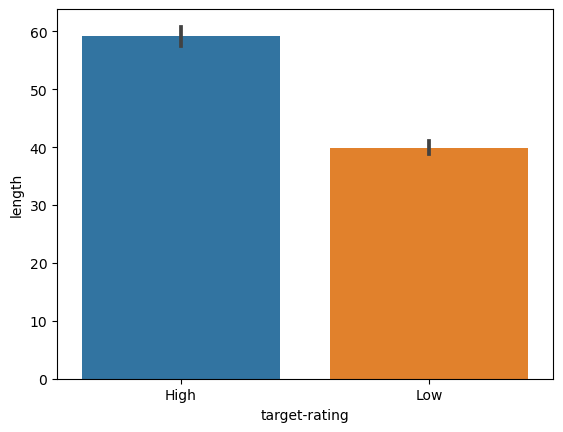

In [14]:
## visualize median review length
# high_len = high['length'].median()
# low_len = low['length'].median()

ax = sns.barplot(data=df, x='target-rating',
                 y='length', errorbar=('ci',68),#estimator='median',
                );

# Show plot before print statement
plt.show()
# print(f' The median character length for {low_len} for low Ratings and {high_len} for high ratings.')

# Save figure
fig = ax.get_figure()

> - ***Add saving image length to Part 00 config***

In [15]:
# # Create a folder for images
# import os
# os.makedirs("images/", exist_ok=True)

# fig.savefig('images/barplot-compare-lengths.png', transparent=False, dpi=300, bbox_inches='tight')

We aren't seeing a big difference here in the lengths of Ratings.  Both high and low seem to averag about 70 characters.  Neutral Ratings seem to be somewhat shorter on average.

These are more informative!  We see words like 'good', 'love', 'hope', 'great', and 'nice' in the highs and 'miss', 'work', 'sad', 'bad', and 'hate' in lows.

While this may not be surprising with high and low sentiments, if we were classifying other kinds of text, like spam emails or patent applications, it could be very enlightening!

## Preparing Data for Modeling


In [16]:
## Import Modeling Package
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### Train Test Split
We created null values in our target column, so we will drop the null values from the rating column before making our X and y data.

In [17]:
# Create a df_ml without null ratings
df_ml = df.dropna(subset=['target-rating'])
df_ml.isna().sum()

asin                    0
reviewerID              0
reviewText              0
summary                 0
overall                 0
year                    0
title                   0
brand                   0
category                0
review-text-full        0
review-text-full_raw    0
tokens-dirty            0
tokens                  0
lemmas                  0
tokens-dirty-joined     0
tokens-joined           0
lemmas-joined           0
target-rating           0
length                  0
dtype: int64

In [18]:
## X - Option A)  lemmas
# def join_tokens(token_list):
#     joined_tokens = ' '.join(token_list)
#     return joined_tokens
# X = df_ml['spacy_lemmas'].apply(join_tokens)

# X - Option B) original raw text
X = df_ml['review-text-full']

# y - use our binary target 
y = df_ml['target-rating']
X.head(10)

2                                                                                                           Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.
3     Its an awesome substitute.: I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI fin...
4                                                                                                                                                   Five Stars: They taste like whatever you cook them with. 
5     Love them!: Coming from an Italian girl who can't resist a pasta dish, these have been my savior for when I'm avoiding carbs but still want a tasty meal. Yes they smell a little funky when you fir...
6     tastes okay: The taste is just okay, but what do you really expect for zero calories?  I ate them for lunch most days while dieting, usually with a little fat free italia

In [19]:
y.value_counts(normalize=True)

High    0.565204
Low     0.434796
Name: target-rating, dtype: float64

### Validation Split

We will perform a triple split.  That way we can tune our model to a validation set and test the final version on a test set.  This avoid tuning our model to specifically perform well on just one set of testing data and gives us a better idea of how our model will perform on new data.

In [20]:
## Train test split
X_train_full, X_test, y_train_names_full, y_test_names = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)
X_train_full.head()

2947    Great!: This stuff is a miracle. Rinse very well for a few minutes, then boil for a couple minutes, then dry fry it in a pan and trim the pasta. I just made chicken pad thai with it. I made my own...
3613                                                                                           Not For Me: When you give up on trying  to chew this up, just swallow it whole.one two three four five six seven
864                                                                                                                     Texture is chewy and smelled like fish!: Nasty! Texture is chewy and smelled like fish!
1872                                                                                    Not a good purchase for me: Opened the package. Yuck.  Followed the directions. Still Yuck. Not a good purchase for me.
2627    Not for me: I really wanted to like these noodles, which I've heard so much about.  But I just couldn't get past the texture and look.  I felt like I was eating

- Using 70% of data as train, 15% as test and 15 % as val (will use in deep nlp codealongs next class)

In [21]:
# ## Split data into train, test, val
# X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42)
# (len(X_train_full), len(X_val), len(X_test))

In [22]:
# Check class balance
y_train_names_full.value_counts(normalize=True)

High    0.555287
Low     0.444713
Name: target-rating, dtype: float64

### Label Encoding

<blockquote style="color:red;font-size:1.5em;"> TO DO: Add label encoder to Part 00 config/filepaths and save here!!</blockquote>

In [23]:
from sklearn.preprocessing import LabelEncoder

# Instansiate label encoder
encoder = LabelEncoder()

# Fit and transform the training target
y_train_full = pd.Series(encoder.fit_transform(y_train_names_full), 
                    index=y_train_names_full.index, 
                    name=y_train_names_full.name)

# Fit and tranform the test target
y_test = pd.Series(encoder.transform(y_test_names), index=y_test_names.index, 
                    name=y_test_names.name)

y_train_names_full[:10]

2947    High
3613     Low
864      Low
1872     Low
2627     Low
1712    High
115     High
3493    High
2910     Low
2919    High
Name: target-rating, dtype: object

In [24]:
y_train_full.value_counts(1)

0    0.555287
1    0.444713
Name: target-rating, dtype: float64

### ~~Under-Sampling Majority Group~~

~~We have a very imbalanced dataset. We will take a small sample from the majority class to match the number of reviews for the minority group.~~

In [25]:
# from imblearn.under_sampling import RandomUnderSampler

In [26]:
# X_train_full#.values.reshape(-1,1)

In [27]:
# # Instantiate a RandomUnderSampler
# sampler = RandomUnderSampler(random_state=42)

# # Fit_resample on the reshaped X_train data and y-train data
# X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),y_train_full)

# # Flatten the reshaped X_train data back to 1D
# X_train = X_train.flatten()

# # Check for class balance
# y_train.value_counts()

In [28]:
y_train = y_train_full
X_train = X_train_full

### Saving training and test data for re-use with ANNs

In [29]:

# Save training data
fpath_train_joblib = FPATHS['data']['ml-nlp']['train_joblib']
print(fpath_train_joblib)
joblib.dump([X_train, y_train],fpath_train_joblib)

# Save test data
fpath_test_joblib = FPATHS['data']['ml-nlp']['test_joblib']
print(fpath_test_joblib)
joblib.dump([X_test, y_test],fpath_test_joblib)


data/modeling/training-data.joblib
data/modeling/testing-data.joblib


['data/modeling/testing-data.joblib']

## Modeling


### DummyClassifier

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      1376
           1       0.44      0.42      0.43      1102

    accuracy                           0.50      2478
   macro avg       0.49      0.49      0.49      2478
weighted avg       0.50      0.50      0.50      2478



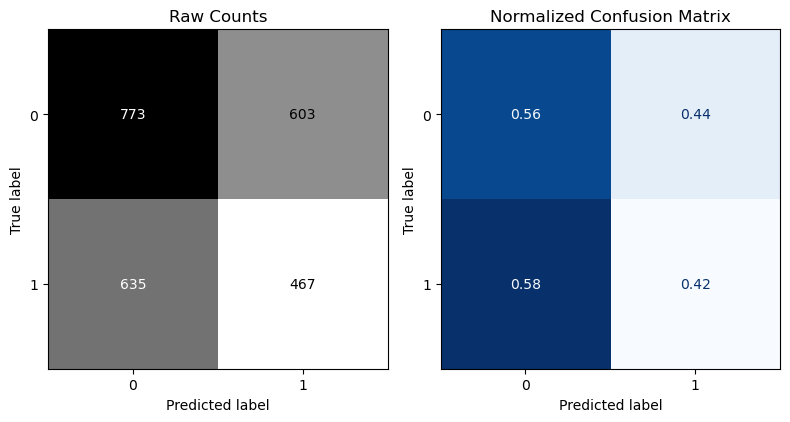


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.57      0.58       492
           1       0.41      0.44      0.42       335

    accuracy                           0.52       827
   macro avg       0.50      0.50      0.50       827
weighted avg       0.52      0.52      0.52       827



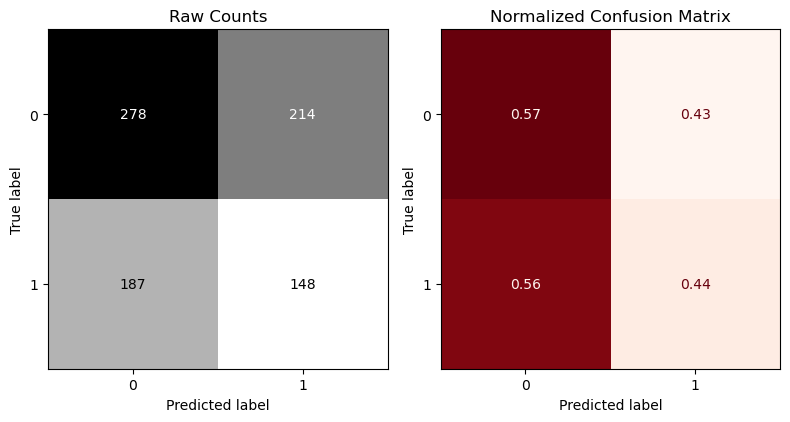

In [30]:
from sklearn.dummy import DummyClassifier
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',DummyClassifier(strategy='stratified'))
])

## Fit an evaluate a Logistic Regression
clf_pipe.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test,figsize=(8,12),values_format=".2g")
# joblib.dump(clf_pipe, FPATHS['models']['ml']['logreg'])

### Naive Bayes

In [31]:
 FPATHS['models']['ml']#['bayes']

{'bayes_joblib': 'models/bayes-clf.joblib',
 'random_forest_joblib': 'models/random-forest.joblib',
 'logreg_joblib': 'models/log-reg.joblib'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1376
           1       0.99      0.99      0.99      1102

    accuracy                           0.99      2478
   macro avg       0.99      0.99      0.99      2478
weighted avg       0.99      0.99      0.99      2478



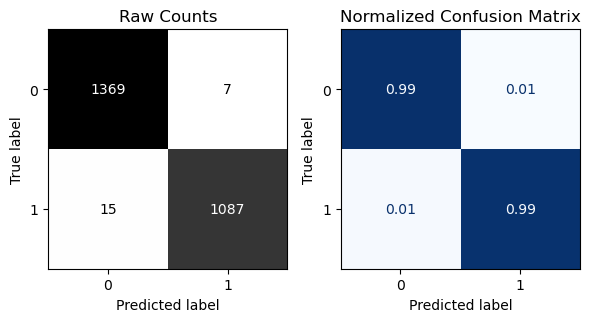


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       492
           1       0.97      0.84      0.90       335

    accuracy                           0.92       827
   macro avg       0.94      0.91      0.92       827
weighted avg       0.93      0.92      0.92       827



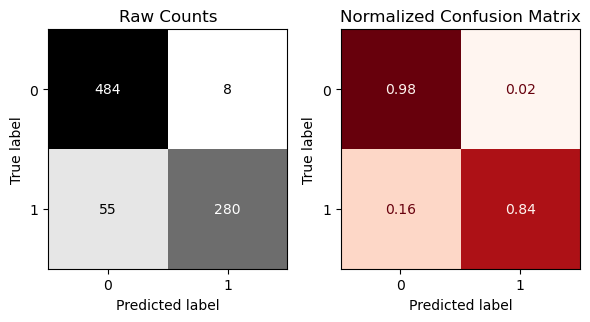

['models/bayes-clf.joblib']

In [32]:
## Create a model pipeline for inference.
vectorizer = CountVectorizer(stop_words='english',
    ngram_range=(1,2)
                            )

clf_bayes = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',MultinomialNB())
])

## Fit an evaluate a Bayesian Model
clf_bayes.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_bayes, X_train,y_train, X_test, y_test)
joblib.dump(clf_bayes, FPATHS['models']['ml']['bayes_joblib'])

In [33]:
# ds.evaluate.evaluate_classification(count_pipe, X_train, y_train, X_test, y_test)

Our model was 95% accurate, but did not seem overly biased against any given class.  There might be a slight bias toward the neutral class.

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1376
           1       1.00      1.00      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



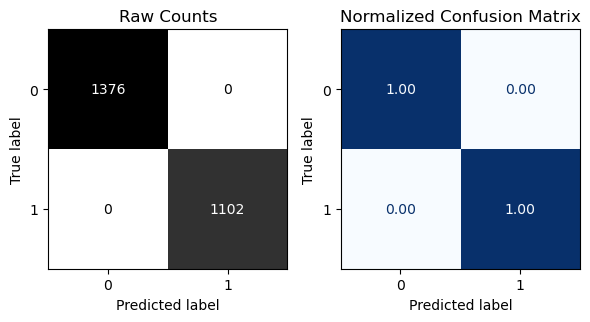


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       492
           1       0.90      0.92      0.91       335

    accuracy                           0.93       827
   macro avg       0.92      0.93      0.93       827
weighted avg       0.93      0.93      0.93       827



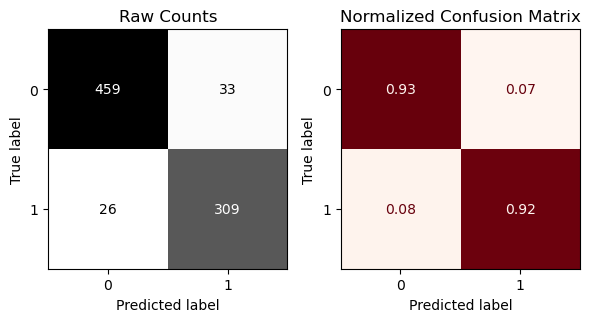

In [34]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegression(max_iter=500,C=1e12))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
# joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg_joblib'])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1376
           1       1.00      1.00      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



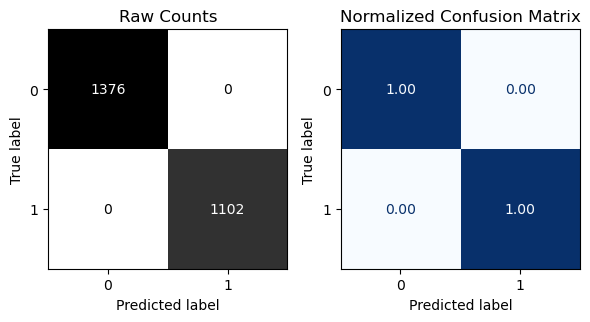


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       492
           1       0.95      0.94      0.94       335

    accuracy                           0.96       827
   macro avg       0.95      0.95      0.95       827
weighted avg       0.96      0.96      0.96       827



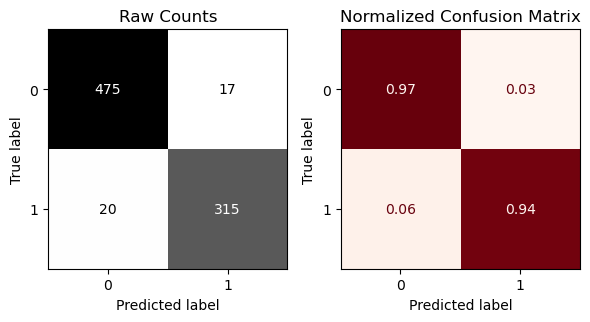

In [35]:
# Logreg-tfidf

vectorizer = TfidfVectorizer(stop_words=None,
    ngram_range=(1,2))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegression(max_iter=500,C=1e12))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
# joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg_joblib'])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1376
           1       1.00      1.00      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



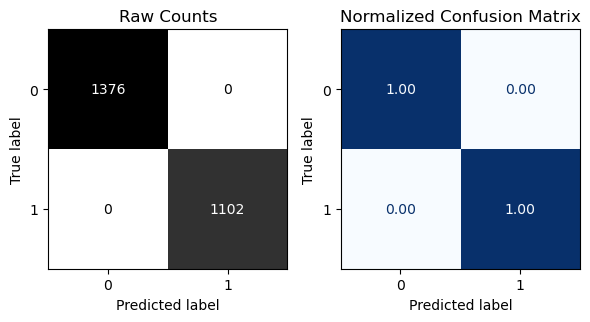


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       492
           1       0.95      0.94      0.95       335

    accuracy                           0.96       827
   macro avg       0.96      0.95      0.95       827
weighted avg       0.96      0.96      0.96       827



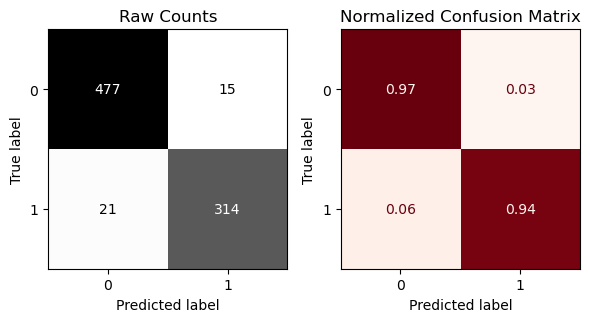

KeyError: 'logreg'

In [36]:
# TEMP COMMENTED OUT
# LogregCV-tfidf 

vectorizer = TfidfVectorizer(stop_words=None,
    ngram_range=(1,2))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegressionCV(max_iter=200))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg'])

### RandomForest

In [ ]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_rf = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',RandomForestClassifier(class_weight='balanced'))
])

## Fit an evaluate a Logistic Regression
clf_rf.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_rf, X_train,y_train, X_test, y_test)
# joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest_joblib'])

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english',
    ngram_range=(1,2))

clf_rf = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',RandomForestClassifier(class_weight='balanced'))
])

## Fit an evaluate a Logistic Regression
clf_rf.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_rf, X_train,y_train, X_test, y_test)
# joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest_joblib'])

### SVC

In [ ]:
from sklearn.svm import SVC, LinearSVC

vectorizer = TfidfVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LinearSVC(class_weight='balanced'))
])

## Fit an evaluate a Logistic Regression
clf_pipe.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test,
                                    # target_names=encoder.classes_,
                                    figsize=(8,10))
# joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest'])

# (Bonus/Optional) GridSearch Text Preprocessing Params

We can tune our text preprocessing choices using gridsearch.

In [ ]:
gs_pipe = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',MultinomialNB())])
gs_pipe.get_params()

In [ ]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]
params_combined

In [ ]:
%%time
# Create grid search
grid_search = GridSearchCV(gs_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_gs_pipe = grid_search.best_estimator_
ds.evaluate.evaluate_classification(best_gs_pipe, X_train, y_train, X_test, y_test)

### RandomForest

In [ ]:
rf_pipe  = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',RandomForestClassifier(class_weight='balanced'))])
rf_pipe.get_params()

In [ ]:
%%time
# Create grid search
grid_search = GridSearchCV(rf_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_rf_pipe = grid_search.best_estimator_
ds.evaluate.evaluate_classification(best_rf_pipe, X_train, y_train, X_test, y_test)

### LogReg

In [ ]:
logreg_pipe  = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',LogisticRegression(max_iter=500, class_weight='balanced'))])
# logreg_pipe.get_params()

In [ ]:
%%time
# Create grid search
grid_search = GridSearchCV(logreg_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_logreg_pipe = grid_search.best_estimator_
ds.evaluate.evaluate_classification(best_logreg_pipe, X_train, y_train, X_test, y_test)